In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
pd.__version__

'2.2.2'

### Data Exploration

In [2]:
# Đọc dữ liệu từ tệp CSV
df = pd.read_csv("train.csv")

# Hiển thị 5 dòng đầu tiên của DataFrame
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
# Hiển thị danh sách các tên cột của DataFrame
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [4]:
# Hiển thị thông tin tóm tắt về DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

### Data Cleaning

In [5]:
# Tính toán số lượng giá trị bị thiếu trong mỗi cột
Missing_values = df.isnull().sum()

# Hiển thị số lượng giá trị bị thiếu
Missing_values

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [6]:
# Tính số lượng giá trị duy nhất trong cột 'Sub-Category'
len(df['Sub-Category'].unique())

17

### TOP 10 BEST SELLING SUB-CATEGORY

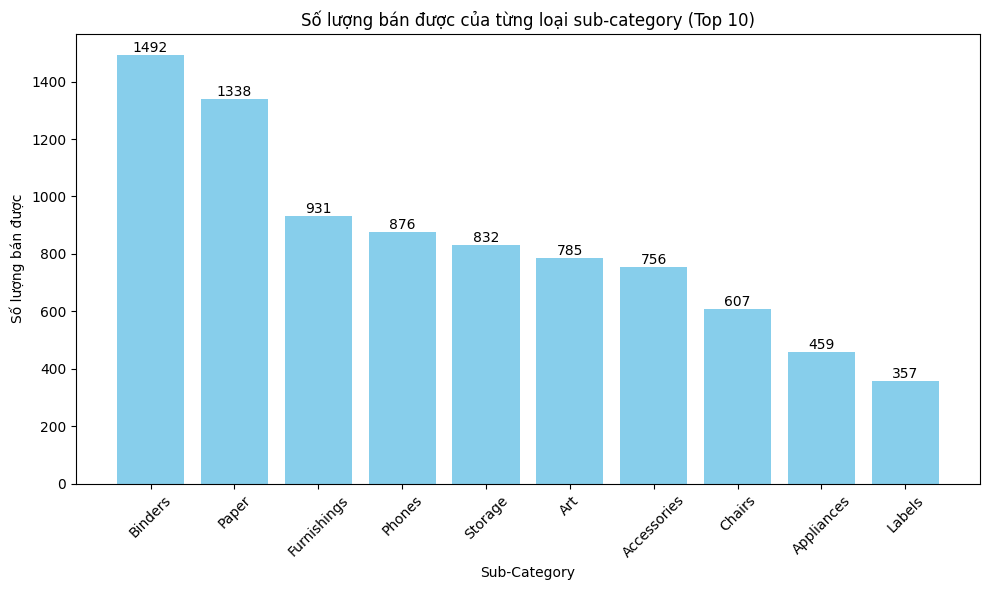

In [7]:
# Tính toán số lượng xuất hiện của từng giá trị trong Sub-Category
sub_category_counts = df['Sub-Category'].value_counts()

# Sắp xếp theo thứ tự giảm dần
sub_category_counts = sub_category_counts.sort_values(ascending=False)

# Lấy top 10
sub_category_counts = sub_category_counts.head(10)

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))

#sub_category_counts.index là danh sách các nhãn (labels) trên trục x (danh sách các giá trị duy nhất trong cột Sub-Category).
#sub_category_counts.values là danh sách các giá trị tương ứng (số lượng xuất hiện của từng giá trị trong Sub-Category).
bars = plt.bar(sub_category_counts.index, sub_category_counts.values, color='skyblue')

# Thêm chú thích cho mỗi cột
for bar in bars:
    yval = bar.get_height() #trả về chiều cao của cột, tức là số lượng bán được
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Sub-Category')
plt.ylabel('Số lượng bán được')
plt.title('Số lượng bán được của từng loại sub-category (Top 10)')
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Tự động điều chỉnh kích thước để tránh trùng lắp
plt.show()

In [8]:
# Chuyển dữ liệu dưới dạng ma trận, với mỗi hàng đại diện cho một đơn hàng và mỗi cột đại diện cho một danh mục sản phẩm
# Xoay bảng lại thành cột ngang là tên danh mục sản phẩm phụ, cột dọc là id đơn hàng, đếm số lần xuất hiện của danh mục sản phẩm trong đơn hàng
hot_encoded_df = df.groupby(['Order ID', 'Sub-Category'])['Sub-Category'].count().unstack().reset_index().fillna(0).set_index('Order ID')

- groupby(['Order ID', 'Sub-Category']): Nhóm dataframe df theo cột 'Order ID' và 'Sub-Category'. Điều này tạo ra một GroupBy object, nơi mỗi nhóm đại diện cho một sự kết hợp duy nhất của đơn hàng và danh mục sản phẩm phụ
- ['Sub-Category'].count(): Đếm số lượng mỗi danh mục sản phẩm phụ xuất hiện trong mỗi đơn hàng
- unstack(): Chuyển dữ liệu từ format "stacked" (dữ liệu được tổ chức theo hàng) sang dạng "unstacked" (dữ liệu được tổ chức theo cột). Điều này chuyển mỗi dmsp thành một cột riêng lẻ, với các giá trị là số lượng đếm được
- reset_index: biến cột index hiện tại(order id) thành một cột thông thường và tạo một index mới từ 0, 1, 2...
- set_index('Order ID'): Lệnh này thiết lập cột 'Order ID' làm chỉ mục mới của DataFrame.
- fillna(0): thay thế các giá trị NaN ( tức là dmsp không xuất hiện trong giao dịch) bằng 0.
=> Kết quả cuối cùng: hot_encoded_df, một df mới mà mỗi hàng đại diện cho một đơn hàng và mỗi cột đại diện cho một dmsp. Gía trị trong bảng cho biết số lượng lần xuất hiện của dmsp trong mỗi đơn hàng.


In [9]:
# Hiển thị 5 dòng đầu tiên của DataFrame
hot_encoded_df.head(10)

Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Order ID,,,,,,,,,,,,,,,,,
CA-2015-100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CA-2015-100090,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CA-2015-100293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
CA-2015-100328,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA-2015-100363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
CA-2015-100391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
CA-2015-100678,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA-2015-100706,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA-2015-100762,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0


In [10]:
# Hiển thị số dòng số cột
print(hot_encoded_df.shape)

(4922, 17)


Chuyển đổi dữ liệu, mặt hàng đã mua là 1, chưa mua là 0

In [11]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
hot_encoded_df = hot_encoded_df.applymap(encode_units)
hot_encoded_df.head(10)

Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Order ID,,,,,,,,,,,,,,,,,
CA-2015-100006,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
CA-2015-100090,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
CA-2015-100293,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
CA-2015-100328,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
CA-2015-100363,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
CA-2015-100391,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
CA-2015-100678,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
CA-2015-100706,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
CA-2015-100762,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


- Support: Độ hỗ trợ cho biết tần suất xuất hiện đồng thời của các mặt hàng trong tất cả các giao dịch. Nó được tính bằng cách lấy số lần xuất hiện của một cặp mặt hàng X và Y chia cho tổng số giao dịch N. 
- Confidence: Độ tin cậy của một quy tắc, X → Y, cho biết khi mặt hàng X được mua thì có bao nhiêu phần trăm sẽ có mặt hàng Y được mua cùng. 
- min_support=0.003: Đây là ngưỡng hỗ trợ tối thiểu để xem xét một itemset là "thường xuyên". min_support là một số thực giữa 0 và 1 và đại diện cho tỷ lệ phần trăm tối thiểu của tổng số giao dịch mà một itemset cần có để được coi là thường xuyên. Ở đây, giá trị 0.003 nghĩa là chỉ những itemsets xuất hiện ít nhất trong 0.3% của tổng số giao dịch mới được xem xét.
use_colnames=True: Thông thường, thuật toán Apriori sẽ trả về các chỉ số cột cho các itemsets thường xuyên. Khi thiết lập use_colnames=True, hàm sẽ trả về tên cột (tức là tên của các items) thay vì chỉ số cột, làm cho kết quả dễ đọc và hiểu hơn.

### Apriori

In [12]:
# Tìm tập hợp mục thường xuyên
frequent_itemsets_apriori = apriori(hot_encoded_df, min_support=0.005 , use_colnames = True)
print(frequent_itemsets_apriori.sort_values('support',ascending=[False]))

      support                     itemsets
3    0.262292                    (Binders)
12   0.236286                      (Paper)
9    0.173710                (Furnishings)
13   0.163145                     (Phones)
14   0.155221                    (Storage)
..        ...                          ...
68   0.005282          (Chairs, Fasteners)
127  0.005079    (Chairs, Phones, Binders)
115  0.005079  (Appliances, Phones, Paper)
29   0.005079      (Supplies, Accessories)
121  0.005079        (Art, Chairs, Phones)

[140 rows x 2 columns]


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


- frequent_itemsets: Đây là DataFrame chứa các itemsets thường xuyên đã được tìm thấy ở bước trước.
- metric='lift': Đây là tiêu chí để đánh giá sự thú vị của một quy tắc liên kết. 'Lift' là một chỉ số đo lường mức độ một quy tắc vượt trội hơn so với kỳ vọng nếu hai items là độc lập. Nếu 'lift' > 1, có nghĩa là sự xuất hiện của A có ảnh hưởng tích cực đến sự xuất hiện của B. 'Lift' = 1 nghĩa là A và B độc lập, và 'lift' < 1 nghĩa là A và B có mối liên hệ tiêu cực (tức là sự xuất hiện của A có ảnh hưởng tiêu cực đến sự xuất hiện của B).
- min_threshold=1: Đây là giá trị ngưỡng tối thiểu cho 'lift'. Chỉ những quy tắc có chỉ số 'lift' ít nhất bằng 1 mới được xem xét. Điều này loại bỏ các quy tắc có mối liên hệ tiêu cực hoặc không có mối liên hệ.

In [13]:
# Tìm các luật kết hợp
rules_apriori = association_rules(frequent_itemsets_apriori, metric='lift',min_threshold=1)
selected_columns_apriori = rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
selected_columns_apriori.head(10)

,antecedents,consequents,support,confidence,lift
0,(Accessories),(Tables),0.008939,0.062678,1.021528
1,(Tables),(Accessories),0.008939,0.145695,1.021528
2,(Appliances),(Binders),0.025599,0.283784,1.081939
3,(Binders),(Appliances),0.025599,0.097599,1.081939
4,(Appliances),(Furnishings),0.016050,0.177928,1.024282
5,(Furnishings),(Appliances),0.016050,0.092398,1.024282
6,(Appliances),(Paper),0.021942,0.243243,1.029444
7,(Paper),(Appliances),0.021942,0.092863,1.029444
8,(Appliances),(Phones),0.015441,0.171171,1.049196
9,(Phones),(Appliances),0.015441,0.094645,1.049196


In [14]:
# Lọc các luật kết hợp dựa trên độ tin cậy (confidence)
selected_columns_apriori[ (rules_apriori['lift'] >= 1) &  (rules_apriori['confidence'] >= 0.2)].sort_values(by=['confidence', 'lift'], ascending=[False, False])

,antecedents,consequents,support,confidence,lift
128,"(Appliances, Storage)",(Binders),0.006095,0.555556,2.118082
116,"(Appliances, Furnishings)",(Binders),0.006705,0.417722,1.592584
86,"(Accessories, Storage)",(Binders),0.008127,0.392157,1.495117
122,"(Appliances, Paper)",(Binders),0.008533,0.388889,1.482658
248,"(Phones, Storage)",(Binders),0.008533,0.368421,1.404623
...,...,...,...,...,...
73,"(Accessories, Binders)",(Furnishings),0.006501,0.201258,1.158586
184,"(Phones, Paper)",(Art),0.006908,0.201183,1.375312
67,"(Art, Paper)",(Accessories),0.005892,0.200000,1.402279
188,"(Art, Paper)",(Storage),0.005892,0.200000,1.288482


### FP-Growth


In [15]:
frequent_itemsets_fpgrowth = fpgrowth(hot_encoded_df , min_support = 0.005 , use_colnames = True)
frequent_itemsets_fpgrowth.head(5)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.163145,(Phones)
1,0.262292,(Binders)
2,0.061357,(Tables)
3,0.236286,(Paper)
4,0.043072,(Fasteners)


In [16]:
# Tìm các luật kết hợp
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric='lift',min_threshold=1)
selected_columns_fpgrowth = rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
selected_columns_fpgrowth.head(10)

,antecedents,consequents,support,confidence,lift
0,(Furnishings),(Phones),0.029256,0.168421,1.032339
1,(Phones),(Furnishings),0.029256,0.179328,1.032339
2,"(Phones, Paper)",(Binders),0.010768,0.313609,1.195651
3,"(Phones, Binders)",(Paper),0.010768,0.271795,1.150279
4,"(Paper, Binders)",(Phones),0.010768,0.198502,1.216720
5,(Phones),"(Paper, Binders)",0.010768,0.066002,1.216720
6,(Paper),"(Phones, Binders)",0.010768,0.045572,1.150279
7,(Binders),"(Phones, Paper)",0.010768,0.041053,1.195651
8,"(Furnishings, Phones)",(Paper),0.007924,0.270833,1.146210
9,"(Phones, Paper)",(Furnishings),0.007924,0.230769,1.328475


In [17]:
# Lọc các luật kết hợp dựa trên độ tin cậy (confidence)
selected_columns_fpgrowth[ (rules_fpgrowth['lift'] >= 1) &  (rules_fpgrowth['confidence'] >= 0.2)].sort_values(by=['confidence', 'lift'], ascending=[False, False])

,antecedents,consequents,support,confidence,lift
260,"(Appliances, Storage)",(Binders),0.006095,0.555556,2.118082
254,"(Appliances, Furnishings)",(Binders),0.006705,0.417722,1.592584
128,"(Accessories, Storage)",(Binders),0.008127,0.392157,1.495117
242,"(Appliances, Paper)",(Binders),0.008533,0.388889,1.482658
204,"(Phones, Storage)",(Binders),0.008533,0.368421,1.404623
...,...,...,...,...,...
109,"(Accessories, Binders)",(Furnishings),0.006501,0.201258,1.158586
50,"(Phones, Paper)",(Art),0.006908,0.201183,1.375312
91,"(Art, Paper)",(Accessories),0.005892,0.200000,1.402279
60,"(Art, Paper)",(Storage),0.005892,0.200000,1.288482


### Kết luận:
- Với những phân tích trên, thì có thể thấy binders là danh mục sản phẩm phổ biến nhất, bán được nhiều nhất
- Khai phá luật kết hợp sẽ giúp nhà bán hàng xác định mối quan hệ giữa các sản phẩm, hiểu rõ hơn hành vi mua sắm của khách hàng, để thiết lập các chiến dịch khuyến mãi, thiết kế các combo bán hàng cùng nhau cho hiệu quả, giúp tăng lợi nhuận, đáp ứng nhu cầu của khách hàng
- Ví dụ: (Storage, Appliances) -> (Binders) , sau khi biết được mối quan hệ giữa (Storage, Appliances) và (Binders), khi khách hàng mua (Storage, Appliances) thì khả năng cao họ cũng sẽ mua (Binders) thì nhà bán hàng sẽ có chiến lược như là sẽ giảm giá binders khi mua kèm với Storage, Appliances , hoặc là bố trí vị trí các danh mục sản phầm này ở gần nhau

### Compare Apriori FP - Growth

In [18]:
import time
from memory_profiler import memory_usage

In [19]:
# Hàm để đo thời gian và bộ nhớ của Apriori
def measure_apriori(df, min_support):
    start_time = time.time()
    mem_usage = memory_usage((apriori, (df,), {'min_support': min_support, 'use_colnames': True}))
    end_time = time.time()
    return end_time - start_time, max(mem_usage) - min(mem_usage)

In [20]:
# Hàm để đo thời gian và bộ nhớ của FP-Growth
def measure_fpgrowth(df, min_support):
    start_time = time.time()
    mem_usage = memory_usage((fpgrowth, (df,), {'min_support': min_support, 'use_colnames': True}))
    end_time = time.time()
    return end_time - start_time, max(mem_usage) - min(mem_usage)

In [21]:
# Thực hiện đo lường
min_support = 0.005

apriori_time, apriori_memory = measure_apriori(hot_encoded_df, min_support)
fpgrowth_time, fpgrowth_memory = measure_fpgrowth(hot_encoded_df, min_support)

# Hiển thị kết quả
print(f"Apriori - Thời gian: {apriori_time} giây, Bộ nhớ: {apriori_memory} MiB")
print(f"FP-Growth - Thời gian: {fpgrowth_time} giây, Bộ nhớ: {fpgrowth_memory} MiB")

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-p

Apriori - Thời gian: 2.2520692348480225 giây, Bộ nhớ: 49.2890625 MiB
FP-Growth - Thời gian: 3.2883622646331787 giây, Bộ nhớ: 0.1796875 MiB


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Phân tích:
- Thời gian thực thi: Apriori nhanh hơn so với FP-Growth trong trường hợp này
- Bộ nhớ sử dụng: FP-Growth sử dụng ít bộ nhớ hơn nhiều so với Apriori

### Kết luận
- Mặc dù Apriori nhanh hơn trong trường hợp này, sự chênh lệch về thời gian không quá lớn. Tuy nhiên, sự khác biệt về bộ nhớ sử dụng là rất đáng kể. FP-Growth sử dụng ít bộ nhớ hơn gấp nhiều lần so với Apriori. Đơn hàng ngày một tăng, xử lý dữ liệu ngày càng lớn thì FP-Growth sẽ nhanh hơn cả về thời gian, vì nó có ưu điểm giảm số lần quét cơ sở dữ liệu, khắc phục được nhược điểm của Apriori khi phải cần nhiều lần quét cơ sở dữ liệu để tạo ra các tập con của các mục có kích thước tăng dần
- Đề xuất: Dựa trên kết quả và phân tích, cửa hàng nên sử dụng FP-Growth vì lợi ích vượt trội về bộ nhớ, thời gian thực thi